Memory usage         39.38 MB
Dataset shape    (166510, 31)


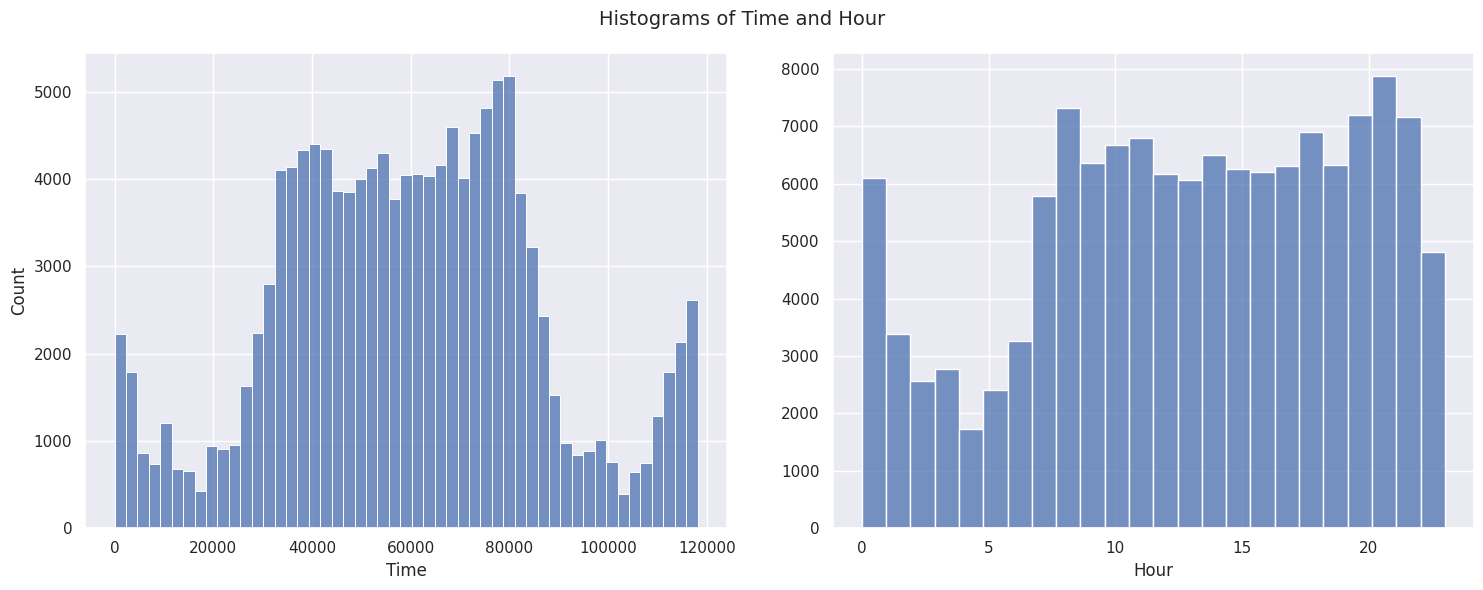

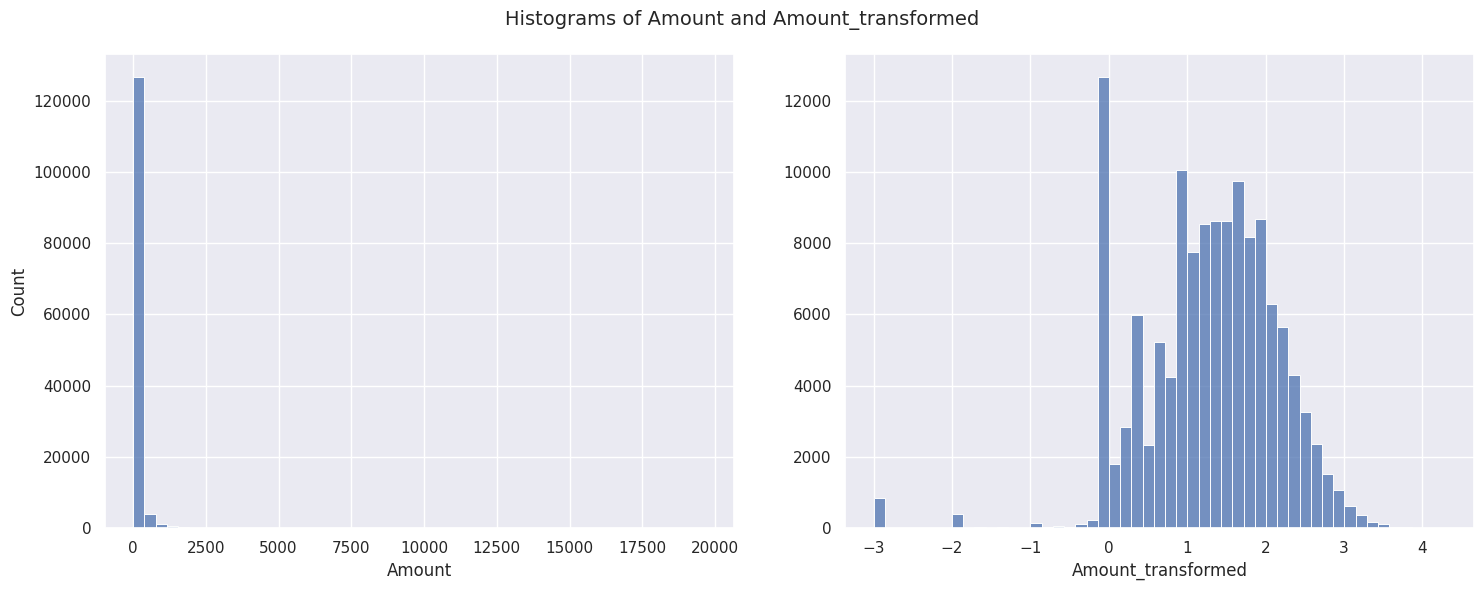

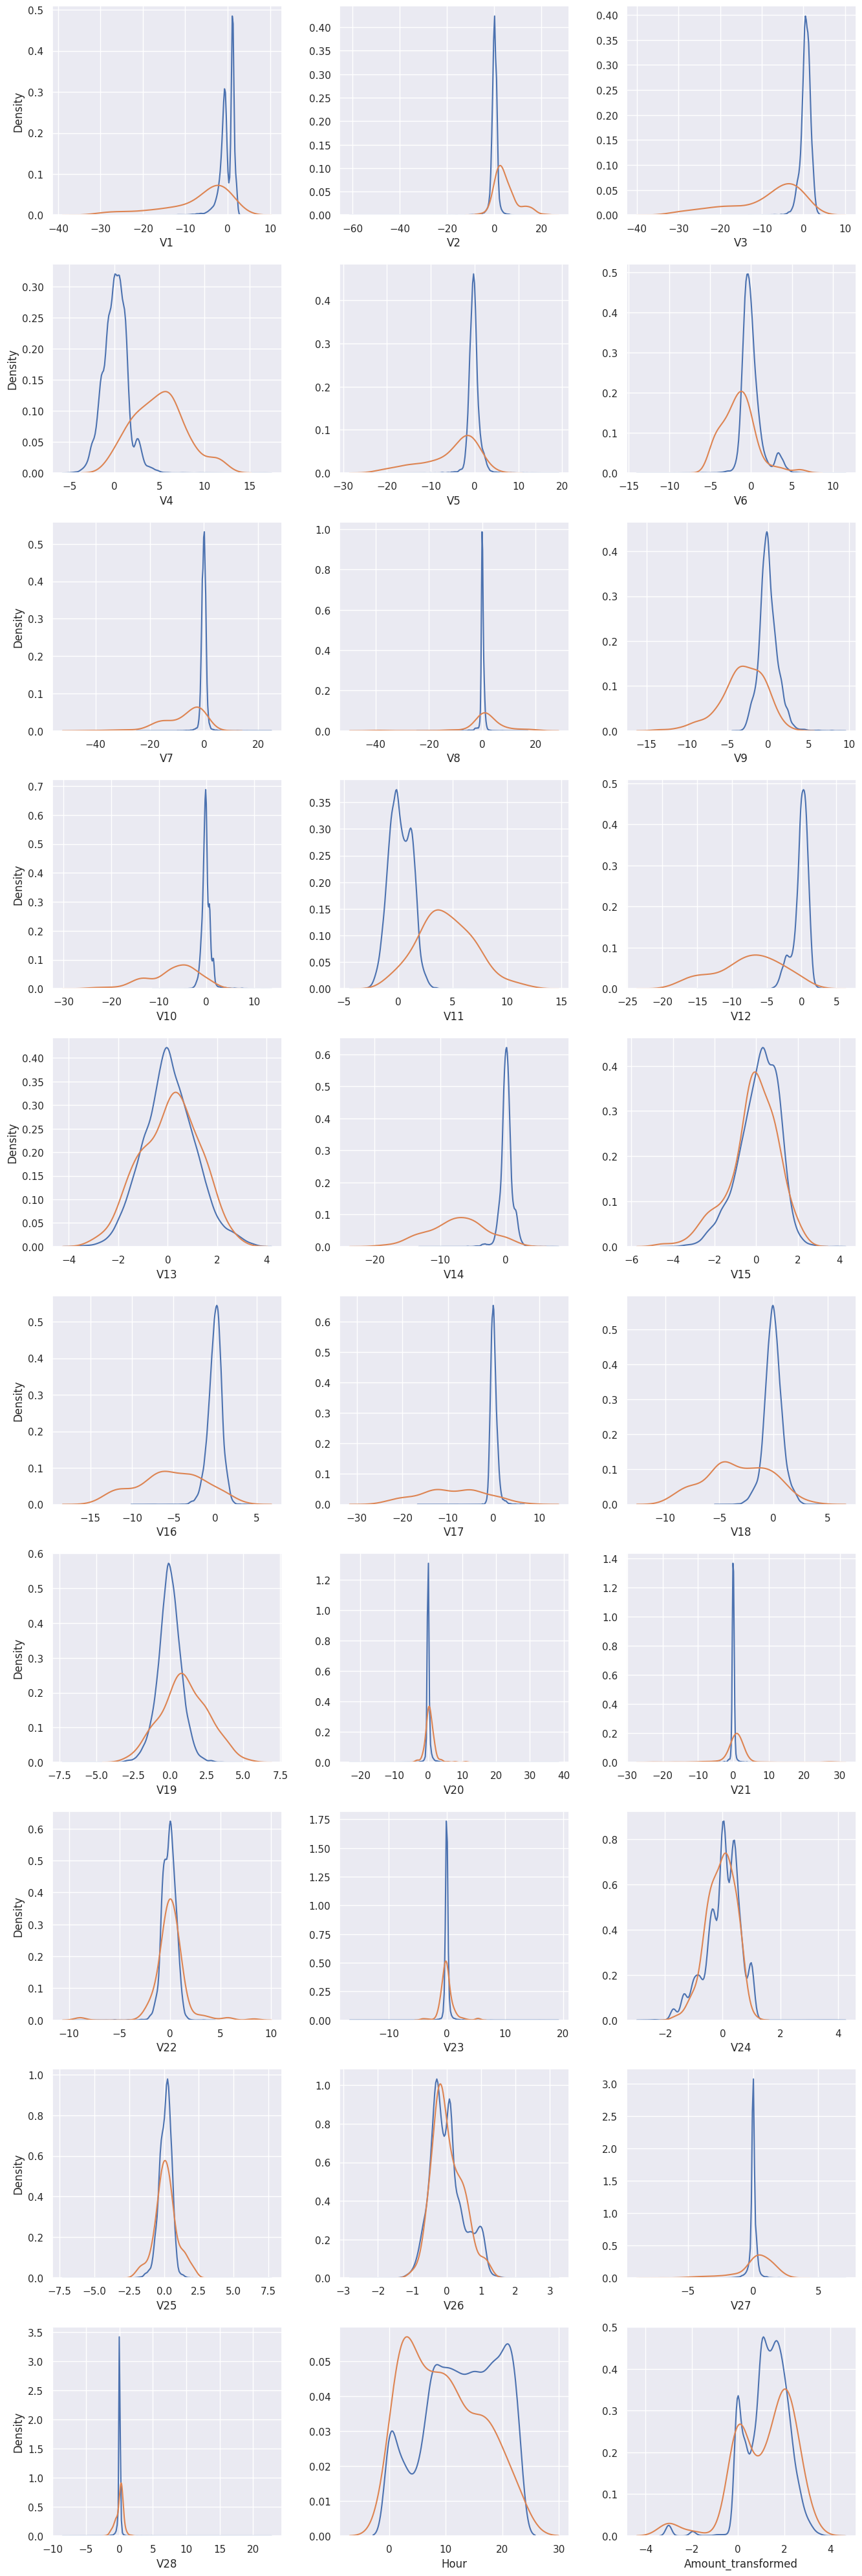

In [1]:
# Install required libraries
!pip install plotly seaborn tqdm psutil pandas numpy scikit-learn

# Import necessary libraries

# File system management
import time, psutil, os, gc

# Mathematical functions
import math

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure
from plotly.offline import init_notebook_mode

# Train-test split
from sklearn.model_selection import train_test_split

# Progress bar for loop
from tqdm.contrib import itertools

# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

# Load the data
data = pd.read_csv('/content/creditcard.csv')  # Make sure the CSV file is in the correct path in Google Colab or Jupyter Notebook
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum() / (1024 * 1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data.head()

# Splitting the data by target class
data_0, data_1 = data[data['Class'] == 0], data[data['Class'] == 1]

# Feature-target split
X_0, y_0 = data_0.drop('Class', axis=1), data_0['Class']
X_1, y_1 = data_1.drop('Class', axis=1), data_1['Class']

# Splitting the authentic class and constructing the training set
X_train, X_test, y_train, y_test = train_test_split(X_0, y_0, test_size=0.2, random_state=40)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=40)
data_val_1, data_test_1 = pd.concat([X_val, y_val], axis=1), pd.concat([X_test, y_test], axis=1)

# Splitting the fraudulent class
X_val, X_test, y_val, y_test = train_test_split(X_1, y_1, test_size=0.5, random_state=40)
data_val_2, data_test_2 = pd.concat([X_val, y_val], axis=1), pd.concat([X_test, y_test], axis=1)

# Merging data to construct the validation set and the test set
data_val, data_test = pd.concat([data_val_1, data_val_2], axis=0), pd.concat([data_test_1, data_test_2], axis=0)
X_val, y_val = data_val.drop('Class', axis=1), data_val['Class']
X_test, y_test = data_test.drop('Class', axis=1), data_test['Class']

# Distribution of authentic and fraudulent transactions over training, validation, and test set
labels = ['Train', 'Validation', 'Test']
values_0 = [len(y_train[y_train == 0]), len(y_val[y_val == 0]), len(y_test[y_test == 0])]
values_1 = [len(y_train[y_train == 1]), len(y_val[y_val == 1]), len(y_test[y_test == 1])]
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]])
fig.add_trace(go.Pie(values=values_0, labels=labels, hole=0.5, textinfo='percent', title="Authentic"),
              row=1, col=1)
fig.add_trace(go.Pie(values=values_1, labels=labels, hole=0.5, textinfo='percent', title="Fraudulent"),
              row=1, col=2)
text_title = "Distribution of authentic and fraudulent transactions over training, validation and test set"
fig.update_layout(height=500, width=800, showlegend=True, title=dict(text=text_title, x=0.5, y=0.95))
fig.show()

# Setting the number of bins
bins_train = math.floor(len(X_train)**(1/3))

# Decomposing time
for df in [X_train, X_val, X_test]:
    df['Day'], temp = df['Time'] // (24 * 60 * 60), df['Time'] % (24 * 60 * 60)
    df['Hour'], temp = temp // (60 * 60), temp % (60 * 60)
    df['Minute'], df['Second'] = temp // 60, temp % 60
X_train[['Time', 'Day', 'Hour', 'Minute', 'Second']].head()

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=False)
sns.histplot(data=X_train, x='Time', bins=bins_train, ax=ax[0])
sns.histplot(data=X_train, x='Hour', bins=24, ax=ax[1])
ax[1].set_ylabel(" ")
plt.suptitle("Histograms of Time and Hour", size=14)
plt.tight_layout()
plt.show()

# Transformation of 'Amount'
for df in [X_train, X_val, X_test]:
    df['Amount_transformed'] = np.log10(df['Amount'] + 0.001)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=False)
sns.histplot(data=X_train, x='Amount', bins=bins_train, ax=ax[0])
sns.histplot(data=X_train, x='Amount_transformed', bins=bins_train, ax=ax[1])
ax[1].set_ylabel(" ")
plt.suptitle("Histograms of Amount and Amount_transformed", size=14)
plt.tight_layout()
plt.show()

# Discarding unnecessary columns
for df in [X_train, X_val, X_test]:
    df.drop(['Time', 'Day', 'Minute', 'Second', 'Amount'], axis=1, inplace=True)

# Comparison of feature distributions for different target classes
data_val = pd.concat([X_val, y_val], axis=1)
data_val_0, data_val_1 = data_val[data_val['Class'] == 0], data_val[data_val['Class'] == 1]
cols, ncols = list(X_val.columns), 3
nrows = math.ceil(len(cols) / ncols)
fig, ax = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 4 * nrows))
for i in range(len(cols)):
    sns.kdeplot(data_val_0[cols[i]], ax=ax[i // ncols, i % ncols])
    sns.kdeplot(data_val_1[cols[i]], ax=ax[i // ncols, i % ncols])
    if i % ncols != 0:
        ax[i // ncols, i % ncols].set_ylabel(" ")
plt.tight_layout()
plt.show()

# Feature selection
cols = ['V4', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Hour']
X_train_fs, X_val_fs, X_test_fs = X_train[cols], X_val[cols], X_test[cols]
X_train_fs.head()

# Normal pdf
def normal_density(x, mu, sigma):
    """
    Computes univariate normal probability density function (pdf) with mean mu, standard deviation sigma
    """
    assert sigma > 0, "Standard deviation must be positive"
    f = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- (1 / 2) * ((x - mu) / sigma)**2)
    return f

# Product of normal pdfs
def normal_product(x_vec, mu_vec, sigma_vec):
    """
    Computes product of univariate normal densities
    """
    assert min(sigma_vec) > 0, "Standard deviation must be positive"
    assert len(mu_vec) == len(x_vec), "Length of mean vector does not match length of input vector"
    assert len(sigma_vec) == len(x_vec), "Length of standard deviation vector does not match length of input vector"
    f = 1
    for i in range(len(x_vec)):
        f = f * normal_density(x_vec[i], mu_vec[i], sigma_vec[i])
    return f

# Model fitting
mu_train, sigma_train = X_train_fs.mean().values, X_train_fs.std().values

# Function to predict anomaly based on probability density threshold
def model_normal(X, epsilon):
    """
    Anomaly detection model
    """
    y = []
    for i in X.index:
        prob_density = normal_product(X.loc[i].tolist(), mu_train, sigma_train)
        y.append((prob_density < epsilon).astype(int))
    return y

# Function to compute confusion matrix
def conf_mat(y_test, y_pred):
    """
    Computes confusion matrix
    """
    y_test, y_pred
